In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join

In [5]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj_{NUMBER_NODES}',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(256, 256),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj_{NUMBER_NODES}',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(256, 256),
        batch_size=32)
    return train_ds, val_ds

In [6]:
train_ds, val_ds = load_data()

Found 940 files belonging to 445 classes.
Using 752 files for training.
Found 940 files belonging to 445 classes.
Using 188 files for validation.


In [7]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=64,
)

Epoch 1/64
24/24 [==============================] - 72s 3s/step - loss: 6.2428 - accuracy: 0.0652 - val_loss: 5.9923 - val_accuracy: 0.1011
Epoch 2/64
24/24 [==============================] - 66s 3s/step - loss: 5.8742 - accuracy: 0.0957 - val_loss: 6.0730 - val_accuracy: 0.1011
Epoch 3/64
24/24 [==============================] - 69s 3s/step - loss: 5.7118 - accuracy: 0.0957 - val_loss: 6.1627 - val_accuracy: 0.1011
Epoch 4/64
24/24 [==============================] - 71s 3s/step - loss: 5.6309 - accuracy: 0.0957 - val_loss: 6.2262 - val_accuracy: 0.1011
Epoch 5/64
24/24 [==============================] - 70s 3s/step - loss: 5.5216 - accuracy: 0.0957 - val_loss: 6.1222 - val_accuracy: 0.1011
Epoch 6/64
24/24 [==============================] - 70s 3s/step - loss: 5.4657 - accuracy: 0.0971 - val_loss: 6.6256 - val_accuracy: 0.1011
Epoch 7/64
24/24 [==============================] - 69s 3s/step - loss: 5.4116 - accuracy: 0.1037 - val_loss: 6.1178 - val_accuracy: 0.1011
Epoch 8/64
24/24 [==

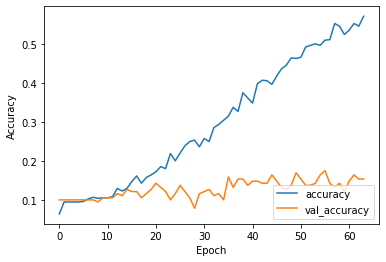

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

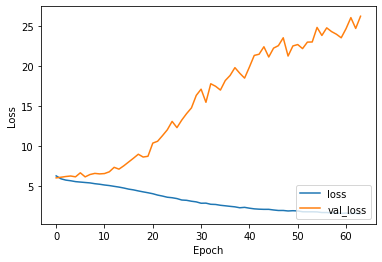

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [10]:
def get_bandwidth_nn_output(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    x, y = np.nonzero(L)
    return (x-y).max()

def processDataToAdjImage(graphInput):
    graph_adj = getGraph(graphInput)
    plt.imshow(graph_adj, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./Graph_adj_test_input.png')
    plt.clf()
    image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_test_input.png')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = np.array([image_input_arr])
    image_input_np = image_input_np / 255.0

    image_input_np = tf.image.resize(image_input_np, [256, 256])
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return arr

In [11]:
def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_adj_graphs_{NUMBER_NODES}/teste_data_{NUMBER_NODES}.csv')
    print(df.shape)

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber + 1 : ].values # skip bandwidth value
    return features, labels

In [12]:
test_features, test_labels = load_test_data()
print(test_features.shape)
print(test_labels.shape)

(104, 29)
(104, 21)
(104, 7)


In [13]:
sumTest_pred = 0
sumTest_true = 0

for x, true in zip(test_features, test_labels):
    get_graph_adj_image_arr = processDataToAdjImage(x)
    pred = model.predict(get_graph_adj_image_arr)
    print("===")
    try:
        print(np.argmax(pred))
        print(class_names.index(str(true)))
    except ValueError:
        print(f"{str(true)} not in class_names")
    
    print("as node list:")
    str_pred_nodelist = class_names[np.argmax(pred)]
    true_nodelist = list(map(int, true))
    print(str_pred_nodelist)
    print(true_nodelist)
    print("Bandwidth")
    arr_pred_nodelist = getArray(str_pred_nodelist)
    arr_true_nodelist = true_nodelist
    graph = getGraph(x)
    
    pred_band = get_bandwidth_nn_output(graph, arr_pred_nodelist)
    sumTest_pred += pred_band
    true_band = get_bandwidth_nn_output(graph, arr_true_nodelist)
    sumTest_true += true_band
    print(pred_band)
    print(true_band)

===
405
[1. 6. 0. 2. 5. 3. 4.] not in class_names
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[1, 6, 0, 2, 5, 3, 4]
Bandwidth
2
1
===
405
145
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[1, 6, 2, 0, 5, 3, 4]
Bandwidth
4
2
===
405
[1. 6. 3. 2. 0. 5. 4.] not in class_names
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[1, 6, 3, 2, 0, 5, 4]
Bandwidth
4
2
===
405
[1. 2. 6. 3. 0. 4. 5.] not in class_names
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[1, 2, 6, 3, 0, 4, 5]
Bandwidth
4
2
===
405
[5. 1. 0. 6. 3. 2. 4.] not in class_names
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[5, 1, 0, 6, 3, 2, 4]
Bandwidth
4
2
===
405
228
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[2, 5, 6, 1, 0, 3, 4]
Bandwidth
4
3
===
405
256
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[3, 0, 6, 4, 2, 5, 1]
Bandwidth
3
2
===
405
134
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[1, 5, 6, 0, 2, 4, 3]
Bandwidth
4
2
===
405
258
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[3, 0, 6, 4, 5, 2, 1]
Bandwidth
3
2
===
405
406
as node list:
[5. 1. 2. 6. 0. 3. 4.]
[5, 1, 2, 6, 0, 4, 3]
Bandwidth
3


<Figure size 432x288 with 0 Axes>

In [14]:
print("Pred bandwidth mean")
print(sumTest_pred / test_features.shape[0])
print("True bandwidth mean")
print(sumTest_true / test_features.shape[0])

Pred bandwidth mean
5.125
True bandwidth mean
3.0384615384615383
